# Page Rotation and Skew Detection

When pages are scanned, they often are scanned at different orientations. For traditional flatbed scanners and many camera-based scanners, there are two different cases:

- rotations by multiples of 90 degrees
- rotations by small angles relative to the pixel coordinate system ("skew")

The `ocrorot` library estimates both page rotation and page skew using deep learning. The models for doing this actually end up being rather different because page rotation is a fairly straightforward shape recognition problem, while page skew estimation involves fine long range geometric modeling (estimates should be accurate to about 0.2 degrees).

The rotation models used here are trained on binarized, white-on-black, 300 dpi pages; you can retrain for other kinds of page images.

# Page Rotation



In [1]:
%pylab inline
rc("image", cmap="gray", interpolation="bicubic")

Populating the interactive namespace from numpy and matplotlib


In [3]:
figsize(10, 10)
import ocrorot
reload(ocrorot)

<module 'ocrorot' from 'ocrorot/__init__.py'>

In [4]:
%%bash
model=rot-000003456-020897.pt
test -f $model || wget -nd https://storage.googleapis.com/tmb-models/$model

The model itself is a fairly typicall object recognition pipeline with max pooling and batch normalization.

In [16]:
rot = ocrorot.RotationEstimator("rot-000003456-020897.pt")
rot.model

Sequential(
  (0): CheckSizes [(1, 128), (1, 512), (256, 256), (256, 256)]
  (1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True)
  (3): ReLU()
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (9): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (11): ReLU()
  (12): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (13): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (15): ReLU()
  (16): Img2FlatSum
  (17): Linear(in_features=64, out_features=64, bias=

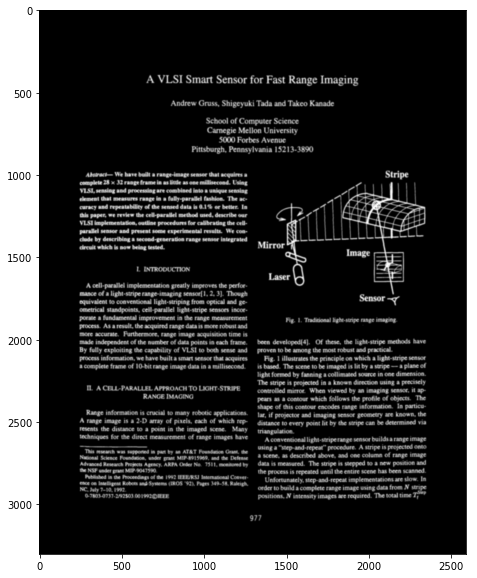

In [8]:
image = 1 - imread("testdata/W1P0.png")
imshow(image)

This page is already at the correct rotation, so the rotation we're getting should be zero.

In [9]:
rot.rotation(image)

0.0

The page rotation estimator works by sampling a number of 256x256 patches from the image and individually classifying them into four classes (corresponding to 0, 90, 180, and 270 degrees). We can plot the output from all these classifiers. 

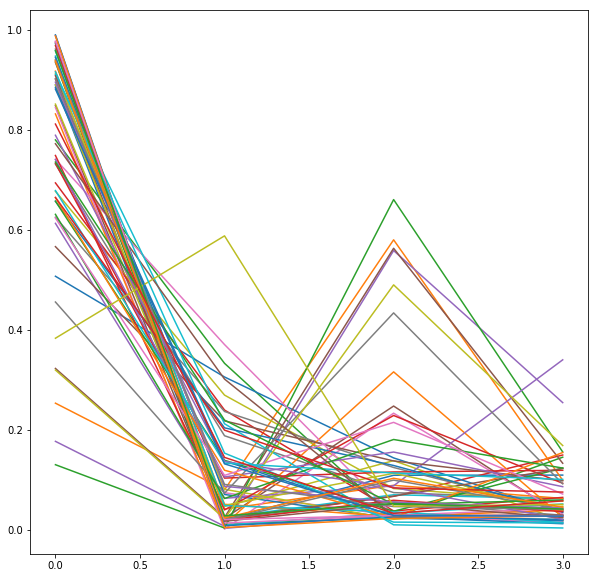

In [13]:
for p in rot.preds: plot(p)

Some of the patches make the wrong prediction because they just don't contain enough information. We could identify these patches by adding a "reject" class and retraining, but that's not been worth it.

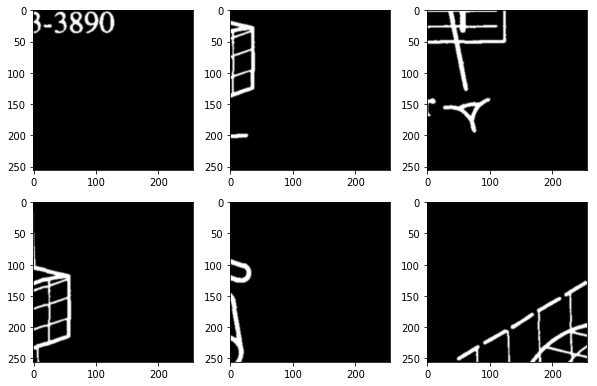

In [15]:
for i, p in enumerate(rot.bad_patches()):
    if i>=9: break
    subplot(3, 3, i+1)
    imshow(p)

In [19]:
del rot

# Page Skew Detection

In [18]:
%%bash
model=logskew-000015808-000132.pt
test -f $model || wget --quiet -nd https://storage.googleapis.com/tmb-models/$model

The skew estimator is a fairly unusual model because it propagates through a global FFT (`Spectrum`).

In [20]:
sk = ocrorot.SkewEstimator("logskew-000015808-000132.pt")
sk.model

Sequential(
  (0): CheckSizes [(1, 128), (1, 512), (256, 256), (256, 256)]
  (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True)
  (3): ReLU()
  (4): Spectrum
  (5): Conv2d(8, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (6): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True)
  (7): ReLU()
  (8): Reshape((0, [1, 2, 3]))
  (9): Linear(in_features=262144, out_features=128, bias=True)
  (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=30, bias=True)
  (13): Sigmoid()
  (14): CheckSizes [(1, 128), (30, 30)]
)

In [22]:
sk.skew(image)

-0.20000000000000018

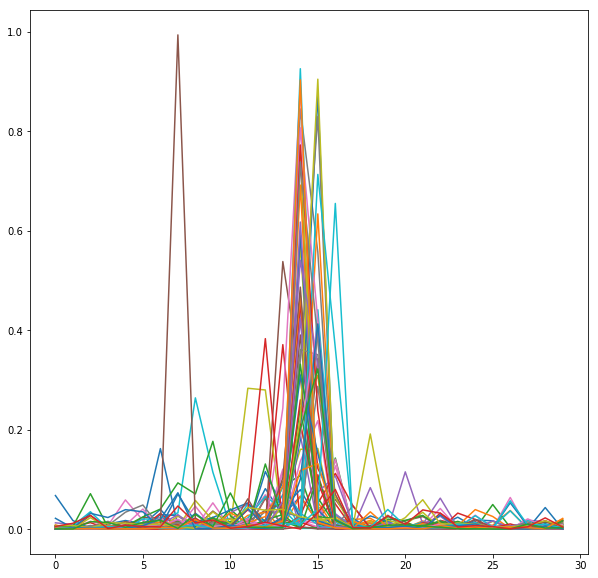

In [24]:
for p in sk.preds:
    plot(p)

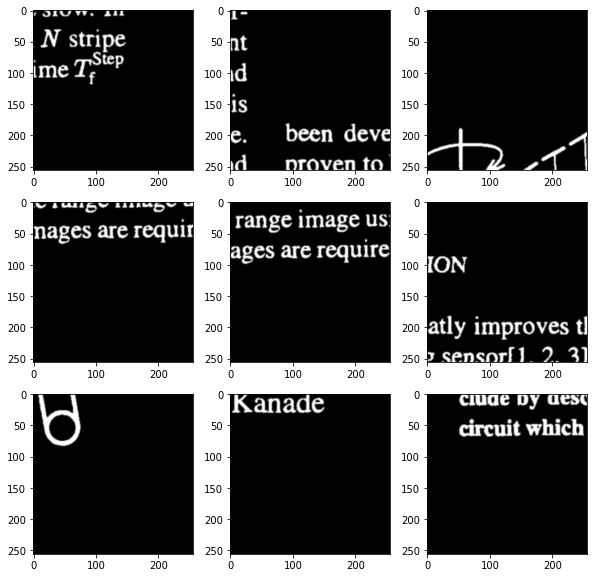

In [25]:
for i, p in enumerate(sk.bad_patches()):
    if i>=9: break
    subplot(3, 3, i+1)
    imshow(p)

# Training

The rotation and skew models are trained on patches. To create the patch databases, we used already deskewed pages and extracted patches at different rotations, then used those for training.